<center>
    COMP4600/5500 - Reinforcement Learning

# Homework 8 - Policy Gradient

### Due: Monday, November 29th 11:59 pm
    
</center>

Student Name: Kevin Lu

The purpose of this project is to study different properties of Policy Gradient algorithms with Function Approximation.

In [1]:
# You are allowed to use the following modules
import numpy as np
import matplotlib.pyplot as plt
from mountain_car import MountainCar
import pygame as pg

pygame 2.0.2 (SDL 2.0.16, Python 3.7.9)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Task description
Consider the task of driving an underpowered car up a steep mountain road, as suggested by the diagram in the upper left of the following figure. The difficulty is that gravity is stronger than the car's engine, and even at full throttle the car cannot accelerate up the steep slope. The only solution is to first move away from the goal and up the opposite slope on the left. Then by applying full throttle the car can build up enough inertia to carry it up the steep slope even though it is slowing down the whole way.


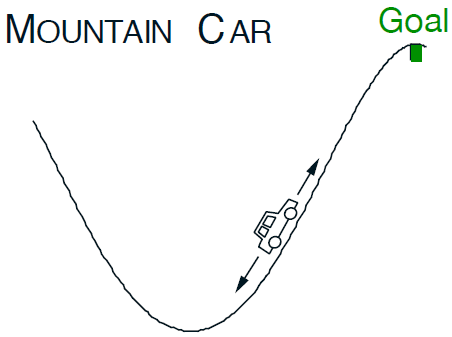


This is a continuous control task where things have to get worse in a sense (farther from the goal) before they can get better. The reward in this problem is -1 on all time steps until the car moves past its goal position at the top of the mountain, which ends the episode. There are three possible actions: full throttle forward (+1), full throttle reverse (-1), and zero throttle (0). The car moves according to a simplified physics. Its position $x_t$ and velocity $\dot{x}_t$ are updated by

$x_{t+1} \doteq \text{bound}[x_t + \dot{x}_{t+1}]$

$\dot{x}_{t+1} \doteq \text{bound}[\dot{x}_t + 0.001 A_t - 0.0025 \cos(3x_t)]$


where the \textit{bound} operation enforces $-1.2 \le x_{t+1} \le 0.5$ and $-0.07 \le \dot{x}_{t+1} \le 0.07$. In addition, when $x_{t+1}$ reached the left bound, $\dot{x}_{t+1}$ was reset to zero. When it reached the right bound, the goal was reached and the episode was terminated. Each episode starts from a random position $x_t \in [-0.6, -0.4)$ and zero velocity.




**Note:** You have been given a simple implementation of the Mountain Car task. You can use your implementation of the function approximation from Homework 6, or implement a new one. 


In [2]:
WIDTH = 640
HEIGHT = 480
CENTER = 6
TS = 10
bg_color = pg.Color(0,0,0)
agent_color = pg.Color(120,120,0)

class Agent:

    def __init__(self, scr, matrix):
        self.w = WIDTH//40
        self.h = HEIGHT//30
        self.x = (5*WIDTH//8)*matrix[0] + WIDTH//1.52
        self.y = -((HEIGHT//4)+(HEIGHT//1.5)*(np.sin(3*matrix[0]) * 0.45 + 0.55)) + HEIGHT//0.86
        self.matrix = matrix
        self.scr = scr
        self.my_rect = pg.Rect((self.x, self.y), (self.w, self.h))

    def show(self, color):
        self.my_rect = pg.Rect((self.x,self.y), (self.w, self.h))
        pg.draw.rect(self.scr, color, self.my_rect)

    def move(self, s):
        pg.time.wait(TS)
        self.x = (5*WIDTH//8)*self.matrix[s] + WIDTH//1.52
        self.y = -((HEIGHT//4)+(HEIGHT//1.5)*(np.sin(3*self.matrix[s]) * 0.45 + 0.55)) + HEIGHT//0.86
        self.show(agent_color)


def animate(m):
    pg.init()
    screen = pg.display.set_mode([WIDTH, HEIGHT])
    agent = Agent(screen, m)
    bg = pg.Surface((agent.w, agent.h))
    bg = bg.convert()
    bg.fill(bg_color)
    screen.blit(bg, (agent.x, agent.y))
    clock = pg.time.Clock()
    plotPoints = []
    x = np.arange(0, WIDTH, 0.01)
    y = np.sin(3 * x) * 0.45 + 0.55
    for x0, y0 in zip(x, y):
        plotPoints.append([(5 * WIDTH // 8) * x0, (HEIGHT // 4) + (HEIGHT // 1.5) * y0])
    pg.draw.lines(screen, [0, 0, 255], False, plotPoints, 2)
    pg.display.flip()
    done = False
    run = True
    while run:
        clock.tick(60)
        for event in pg.event.get():
            if event.type == pg.QUIT:
                run = False
            elif done is False:
                for s in range(len(m)):
                    agent.move(s)
                    if s == len(m) - 1:
                        done = True
                        break
                    agent.show(agent_color)
                    pg.display.flip()
                    pg.display.update()
                    screen.blit(bg, (agent.x, agent.y))
        pg.display.flip()
        pg.display.update()
    pg.quit()

In [3]:
def fourier(tuple):

    states = np.asarray(tuple)
    fourier_x = np.interp(states[0], (-1.2, 0.5), (0, 1))
    fourier_v = np.interp(states[1], (-0.07, 0.07), (0, 1))

    states = (fourier_x, fourier_v)

    order_approx1 = [0, 1, 2, 3]
    order_approx2 = [0, 1, 2, 3]
    c = [[o1,o2] for o1 in order_approx1 for o2 in order_approx2]

    #x = np.cos(np.pi * (c @ states))
    x = np.cos(np.pi * np.matmul(c,states))

    return c,x

In [4]:
def x_s_a(x,a):
    x_sa = np.zeros(3*len(x))

    if a == -1:
        for i,x_i in enumerate(x):
            x_sa[i] = x_i

    elif a == 0:
        for i,x_i in enumerate(x):
            x_sa[len(x)+i] = x_i

    elif a == 1:
        for i,x_i in enumerate(x):
            x_sa[2*len(x)+i] = x_i

    return x_sa

In [5]:
def softmax(theta, x):
    x_s1, x_s2, x_s3 = x_s_a(x, -1), x_s_a(x, 0), x_s_a(x, 1)
    h1, h2, h3 = np.matmul(np.transpose(theta), x_s1), np.matmul(np.transpose(theta), x_s2), np.matmul(np.transpose(theta), x_s3)
    h_sum = [h1,h2,h3]
    pi = np.exp(h_sum)/np.sum(np.exp(h_sum))

    return pi

In [6]:
def value_func(w, x):
    v = np.matmul(np.transpose(w), x)

    return v

In [7]:
def grad_ln_pi(pi, x, a):
    x_sa, x_s1, x_s2, x_s3 = x_s_a(x, a), x_s_a(x, -1), x_s_a(x, 0), x_s_a(x, 1)
    b1, b2, b3 = pi[0], pi[1], pi[2]
    b1, b2, b3 = b1*x_s1, b2*x_s2, b3*x_s3
    grad = x_sa - (b1+b2+b3)

    return grad

## Part I (COMP4600)

Implement REINFORCE with Baseline (p. 330).



In [ ]:
#See Part III for code

## Part I (COMP5500)

Implement ACTOR-CRITIC with Eligibility Trace (p. 332).



In [8]:
# Your code here (you are allowed to import from an external python file (of your own impmenetation) 
# instead of copying all the code here)
def actor_critic():
    gamma = 1
    total_episodes = []
    total_reward = []

    car = MountainCar()
    actions = car.actions
    x_0 = np.random.uniform(low=-0.6, high=-0.4)

    start = (x_0, 0)
    c, x = fourier(start)
    theta = np.zeros((len(actions) * len(c)))
    w = np.zeros(len(c))
    lambda_theta, lambda_w = 0.8, 0.8
    a_theta, a_w = 5e-4, 5e-4

    for episode in range(50):
        car = MountainCar()
        actions = car.actions

        x_0 = np.random.uniform(low=-0.6, high=-0.4)
        start = (x_0, 0)

        state_history = []
        reward_history = []

        z_theta, z_w = np.zeros(len(theta)), np.zeros(len(w))
        I = 1
        timestep = 0
        s = start

        while True:
            c, x = fourier(s)
            pi = softmax(theta, x)
            a = np.random.choice(actions, p=pi)
            xp, vp, reward, goal_reached = car.move(s[0], s[1], a)
            next_s = (xp, vp)
            state_history.append(next_s)
            reward_history.append(reward)

            c, next_x = fourier(next_s)

            if goal_reached is True:
                delta = reward - value_func(w, x)
            else:
                delta = reward + gamma*value_func(w, next_x) - value_func(w, x)

            z_w = (gamma * lambda_w * z_w) + x
            z_theta = (gamma * lambda_theta * z_theta) + (I * grad_ln_pi(pi, x, a))
            w += a_w * delta * z_w
            theta += a_theta * delta * z_theta
            I *= gamma
            s = next_s

            if goal_reached is True:
                break

            else:
                timestep += 1

        total_episodes.append(timestep)
        total_reward.append(sum(reward_history))

    return total_episodes, total_reward

## Part II

Use the algorithm to learn the Mountain Car task. Tune the step-size parameter ($\alpha$), the Function Approximation order, the discount factor ($\gamma$), and the $\lambda$-value. **Note:** you can consider the problem to be undiscounted.
 
1. Plot step-per-episode (in log scale) vs. number of episodes. This plot should be averaged over 50-100 runs. 
2. Plot total reward on episode vs. number of episodes. This plot should be averaged over 50-100 runs.
3. Show an animation of the task for the final episode.


In [16]:
def ac_runs(runs):

    total_eps = []
    total_r = []

    for i in range(runs):
        result = actor_critic()
        print(i)
        total_eps.append(result[0])
        total_r.append(result[1])

    return total_eps, total_r

In [28]:
def plot_total_eps(total_eps):
    episodes = []

    for i in range(50):
        episodes.append(i)
    
    plt.figure(figsize = (10,8))
    plt.plot(episodes, np.mean(np.asarray(total_eps), axis=0), label="gamma = 1, a = 5e-4")
    plt.yscale('log')
    plt.xlabel("episodes")
    plt.ylabel("log scale")
    plt.title("Mountain Car: Actor-Critic Episodic: Step per Episode")
    plt.legend()
    plt.show()

In [29]:
def plot_total_rewards(total_rewards):
    episodes = []

    for i in range(50):
        episodes.append(i)
    
    plt.figure(figsize = (10,8))
    plt.plot(episodes, np.mean(np.asarray(total_rewards), axis=0), label="gamma = 1, a = 5e-4")
    plt.xlabel("episodes")
    plt.ylabel("total rewards")
    plt.title("Mountain Car: Actor-Critic Episodic: Total Rewards per Episode")
    plt.legend()
    plt.show()

In [19]:
actor_critic()
total_eps, total_rewards = ac_runs(50)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


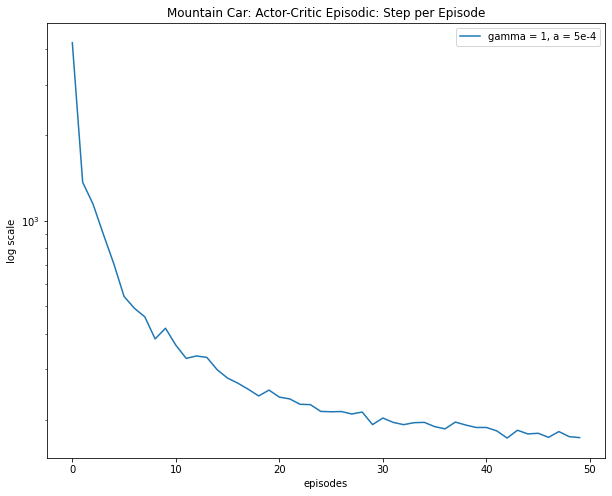

In [30]:
plot_total_eps(total_eps)

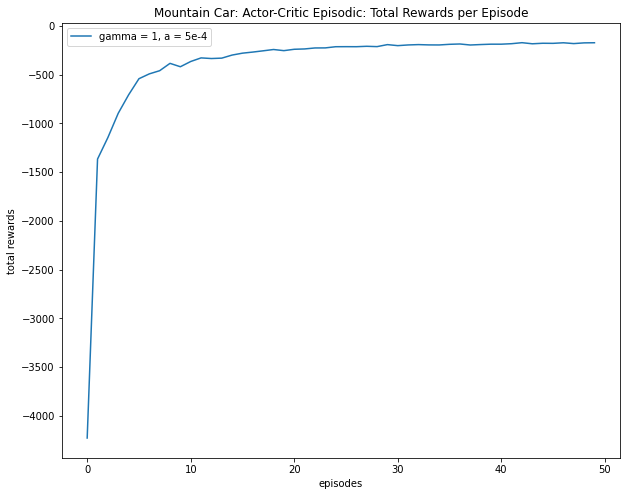

In [31]:
plot_total_rewards(total_rewards)

In [32]:
def actor_critic_final_ep():
    gamma = 1
    
    final_eps = []

    car = MountainCar()
    actions = car.actions
    x_0 = np.random.uniform(low=-0.6, high=-0.4)

    start = (x_0, 0)
    c, x = fourier(start)
    theta = np.zeros((len(actions) * len(c)))
    w = np.zeros(len(c))
    lambda_theta, lambda_w = 0.8, 0.8
    a_theta, a_w = 5e-4, 5e-4

    for episode in range(50):
        car = MountainCar()
        actions = car.actions

        x_0 = np.random.uniform(low=-0.6, high=-0.4)
        start = (x_0, 0)

        state_history = []
        reward_history = []

        z_theta, z_w = np.zeros(len(theta)), np.zeros(len(w))
        I = 1
        timestep = 0
        s = start

        while True:
            c, x = fourier(s)
            pi = softmax(theta, x)
            a = np.random.choice(actions, p=pi)
            xp, vp, reward, goal_reached = car.move(s[0], s[1], a)
            next_s = (xp, vp)
            state_history.append(next_s)
            reward_history.append(reward)

            c, next_x = fourier(next_s)

            if goal_reached is True:
                delta = reward - value_func(w, x)
            else:
                delta = reward + gamma * value_func(w, next_x) - value_func(w, x)

            z_w = (gamma * lambda_w * z_w) + x
            z_theta = (gamma * lambda_theta * z_theta) + (I * grad_ln_pi(pi, x, a))
            w += a_w * delta * z_w
            theta += a_theta * delta * z_theta
            I *= gamma
            s = next_s

            if goal_reached is True:
                break

            else:
                timestep += 1

        if episode == 49:
            final_eps.append(state_history)

    return state_history

In [34]:
final_eps = actor_critic_final_ep()
final_eps = np.asarray(final_eps)[:, 0]
print(final_eps)

[-0.45600559 -0.45500888 -0.45352297 -0.45355877 -0.45311601 -0.45419794
 -0.45479662 -0.45490766 -0.45453025 -0.45366715 -0.45432471 -0.45449808
 -0.45518601 -0.45638343 -0.45908157 -0.46126056 -0.46290438 -0.46500089
 -0.46853462 -0.47347946 -0.47979878 -0.48744565 -0.49436314 -0.50249962
 -0.51179424 -0.52217737 -0.53257116 -0.54389767 -0.55607203 -0.56900322
 -0.58259494 -0.59674649 -0.61135382 -0.62631057 -0.64150911 -0.65484165
 -0.66821511 -0.68153765 -0.69371947 -0.70468006 -0.71534837 -0.72365656
 -0.72955279 -0.73400079 -0.73597348 -0.73745897 -0.73744829 -0.73494153
 -0.73195378 -0.72850315 -0.72261071 -0.71431279 -0.70366128 -0.69072403
 -0.6755852  -0.65834556 -0.63912262 -0.61805049 -0.59527942 -0.57097487
 -0.5453162  -0.51849476 -0.4907116  -0.4621747  -0.43309587 -0.40368751
 -0.3741592  -0.34471453 -0.31554801 -0.28684252 -0.25876712 -0.23147549
 -0.20510492 -0.17977582 -0.15759186 -0.13663367 -0.11696839 -0.10065075
 -0.08572001 -0.07220706 -0.06013569 -0.04952374 -0

In [46]:
animate(final_eps)

## Part III*

Implement the other algorithm and include plots for both algorithms in part II.

In [42]:
#Spent a long time trying to tune the alpha values but it wasn't working properly
#Code should be correct

In [37]:
def reinforce_baseline():
    gamma = 1
    total_episodes = []
    total_reward = []

    car = MountainCar()
    actions = car.actions
    x_0 = np.random.uniform(low=-0.6, high=-0.4)

    start = (x_0, 0)
    c, x = fourier(start)
    theta = np.zeros((len(actions) * len(c)))
    w = np.zeros(len(c))
    a_theta, a_w = 2e-9, 2e-6

    for episode in range(50):
        car = MountainCar()
        actions = car.actions

        x_0 = np.random.uniform(low=-0.6, high=-0.4)
        start = (x_0, 0)

        state_history = []
        action_history = []
        reward_history = []
        policy_history = []

        timestep = 0
        s = start

        while True:
            c, x = fourier(s)
            pi = softmax(theta, x)
            a = np.random.choice(actions, p=pi)
            xp, vp, reward, goal_reached = car.move(s[0], s[1], a)
            next_s = (xp, vp)
            state_history.append(next_s)
            reward_history.append(reward)
            action_history.append(a)
            policy_history.append(pi)
            s = next_s

            if goal_reached is True:
                break

            else:
                timestep += 1
                print(timestep)

        for t, sh in enumerate(state_history):
            a, pi = action_history[t], policy_history[t]
            G = -1 * (len(state_history) - t)
            c, sh_x = fourier(sh)
            delta = G - value_func(w, sh_x)
            w += a_w * delta * sh_x
            theta += a_theta * (gamma ** t) * delta * (grad_ln_pi(pi, sh_x, a))

        total_episodes.append(timestep)
        total_reward.append(sum(reward_history))

    return total_episodes, total_reward

In [38]:
def r_runs(runs):

    total_eps = []
    total_r = []

    for i in range(runs):
        result = reinforce_baseline()
        print(i)
        total_eps.append(result[0])
        total_r.append(result[1])

    return total_eps, total_r

In [39]:
def r_plot_total_eps(total_eps):
    episodes = []

    for i in range(50):
        episodes.append(i)

    plt.plot(episodes, np.mean(np.asarray(total_eps), axis=0), label="a_t = 2e-9, a_w = 2e-6")
    plt.yscale('log')
    plt.xlabel("episodes")
    plt.ylabel("log scale")
    plt.title("Mountain Car: Reinforce with Baseline Episodic: Step per Episode")
    plt.legend()
    plt.show()

In [40]:
def r_plot_total_rewards(total_rewards):
    episodes = []

    for i in range(50):
        episodes.append(i)

    plt.plot(episodes, np.mean(np.asarray(total_rewards), axis=0), label="a_t = 2e-9, a_w = 2e-6")
    plt.xlabel("episodes")
    plt.ylabel("total rewards")
    plt.title("Mountain Car: Reinforce with Baseline Episodic: Total Rewards per Episode")
    plt.legend()
    plt.show()

In [ ]:
r_total_eps, r_total_rewards = r_runs(50)

In [ ]:
plot_total_eps(r_total_eps)

In [ ]:
plot_total_rewards(r_total_rewards)

In [41]:
def reinforce_baseline_final_eps():
    gamma = 1
    final_eps = []

    car = MountainCar()
    actions = car.actions
    x_0 = np.random.uniform(low=-0.6, high=-0.4)

    start = (x_0, 0)
    c, x = fourier(start)
    theta = np.zeros((len(actions) * len(c)))
    w = np.zeros(len(c))
    a_theta, a_w = 2e-9, 2e-6

    for episode in range(50):
        car = MountainCar()
        actions = car.actions

        x_0 = np.random.uniform(low=-0.6, high=-0.4)
        start = (x_0, 0)

        state_history = []
        action_history = []
        reward_history = []
        policy_history = []

        timestep = 0
        s = start

        while True:
            c, x = fourier(s)
            pi = softmax(theta, x)
            a = np.random.choice(actions, p=pi)
            xp, vp, reward, goal_reached = car.move(s[0], s[1], a)
            next_s = (xp, vp)
            state_history.append(next_s)
            reward_history.append(reward)
            action_history.append(a)
            policy_history.append(pi)
            s = next_s

            if goal_reached is True:
                break

            else:
                timestep += 1
                print(timestep)

        for t, sh in enumerate(state_history):
            a, pi = action_history[t], policy_history[t]
            G = -1 * (len(state_history) - t)
            c, sh_x = fourier(sh)
            delta = G - value_func(w, sh_x)
            w += a_w * delta * sh_x
            theta += a_theta * (gamma ** t) * delta * (grad_ln_pi(pi, sh_x, a))

        if episode == 49:
            final_eps.append(state_history)
    
    return final_eps 

In [ ]:
r_final_eps = reinforce_baseline_final_eps()
r_final_eps = np.asarray(r_final_eps)[:, 0]
print(r_final_eps)

In [ ]:
animate(r_final_eps)